In [3]:
import os

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pyarrow.parquet as pq
import seaborn as sns

In [4]:
s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

csv_key = "crsp_2023_clean.csv"
file_path = f"../data/{csv_key}"
s3.download_file(bucket, csv_key, file_path)

In [5]:
df = pd.read_csv(file_path)
df["date"] = pd.to_datetime(df["date"])

In [6]:
df.dtypes

PERMNO             int64
date      datetime64[ns]
PRC              float64
RET              float64
dtype: object

In [7]:
df.groupby("PERMNO").count()

,date,PRC,RET
PERMNO,,,
10026,250,250,250
10028,250,250,250
10032,250,250,250
10044,250,250,250
10065,250,250,250
...,...,...,...
93426,250,250,250
93427,250,250,250
93429,250,250,250


In [172]:
np.random.seed(1234)
# sampled_permno = df["PERMNO"].sample(50).tolist()
sampled_permno = df["PERMNO"].sample(50).tolist()

In [173]:
df_sample = df[df["PERMNO"].isin(sampled_permno)]
df_pivot = df_sample.pivot(index="date", columns="PERMNO", values="RET")
df_pivot.head()

PERMNO,10294,10649,12552,13737,13867,13978,14178,14882,15685,15890,...,80128,82745,87251,88404,89372,89606,89649,90228,91968,92834
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,0.003125,-0.008880,-0.002677,-0.011756,-0.005192,0.030812,0.000751,0.015865,-0.004431,-0.006728,...,-0.019566,-0.003415,0.015190,-0.001687,0.015385,0.027650,0.025300,0.048112,0.001388,0.002008
2023-01-04,0.008527,-0.008960,0.009409,0.038662,-0.028184,0.051630,0.009370,0.074065,0.009822,0.012194,...,-0.008359,0.005874,0.019950,0.017887,0.004545,-0.003363,0.018831,0.025716,-0.002772,0.009521
2023-01-05,-0.008130,-0.027909,-0.005997,-0.025770,0.015038,-0.005168,-0.003683,-0.064331,-0.008042,-0.005061,...,-0.013064,-0.009732,-0.044499,-0.008005,-0.004525,0.000000,0.014659,0.022809,-0.011814,-0.006287
2023-01-06,0.058689,0.035584,0.011712,0.028655,0.048677,0.018182,0.004830,0.038615,0.024516,0.024711,...,0.026821,0.000000,0.033777,0.026572,0.018182,0.031496,0.025126,0.026347,0.022503,0.020313
2023-01-09,-0.000619,0.003905,0.006935,-0.015171,0.046418,-0.020408,0.002714,-0.013829,-0.002040,0.000097,...,-0.010466,-0.022113,0.006436,0.000383,0.004464,0.031625,-0.017157,-0.003667,0.006190,0.002285


In [174]:
date_cutoff = pd.Timestamp("2023-10-01")

In [175]:
train = df_pivot[:date_cutoff]
train_span = len(train)
train_span

187

In [176]:
test = df_pivot[date_cutoff:]
test_span = len(test)
test_span

63

In [177]:
train.index

DatetimeIndex(['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-17',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', name='date', length=187, freq=None)

Reference: https://github.com/zhuodannychen/Portfolio-Optimization

In [178]:
from pypfopt import expected_returns, risk_models
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov

mu = expected_returns.ema_historical_return(train, returns_data=True, span=train_span)
Sigma = risk_models.exp_cov(train, returns_data=True, span=train_span)
risk_free_rate = 0.04  # average of 10Y treasury in 2023

**The covariance matrix is not positive definite because it is singular. That means that at least one of your variables can be expressed as a linear combination of the others. You do not need all the variables as the value of at least one can be determined from a subset of the others. I would suggest adding variables sequentially and checking the covariance matrix at each step. If a new variable creates a singularity drop it and go on the the next one. Eventually you should have a subset of variables with a postive definite covariance matrix.**

In [179]:
ret_ef = np.arange(0, 0.879823, 0.01)
vol_ef = []
for i in np.arange(0, 0.879823, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    ef.efficient_return(i)
    vol_ef.append(ef.portfolio_performance()[1])

ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()
min_vol_ret = ef.portfolio_performance(risk_free_rate=risk_free_rate)[0]
min_vol_vol = ef.portfolio_performance(risk_free_rate=risk_free_rate)[1]

ef_sharp = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef_sharp.max_sharpe(risk_free_rate=risk_free_rate)
max_sharpe_ret = ef_sharp.portfolio_performance(risk_free_rate=risk_free_rate)[0]
max_sharpe_vol = ef_sharp.portfolio_performance(risk_free_rate=risk_free_rate)[1]

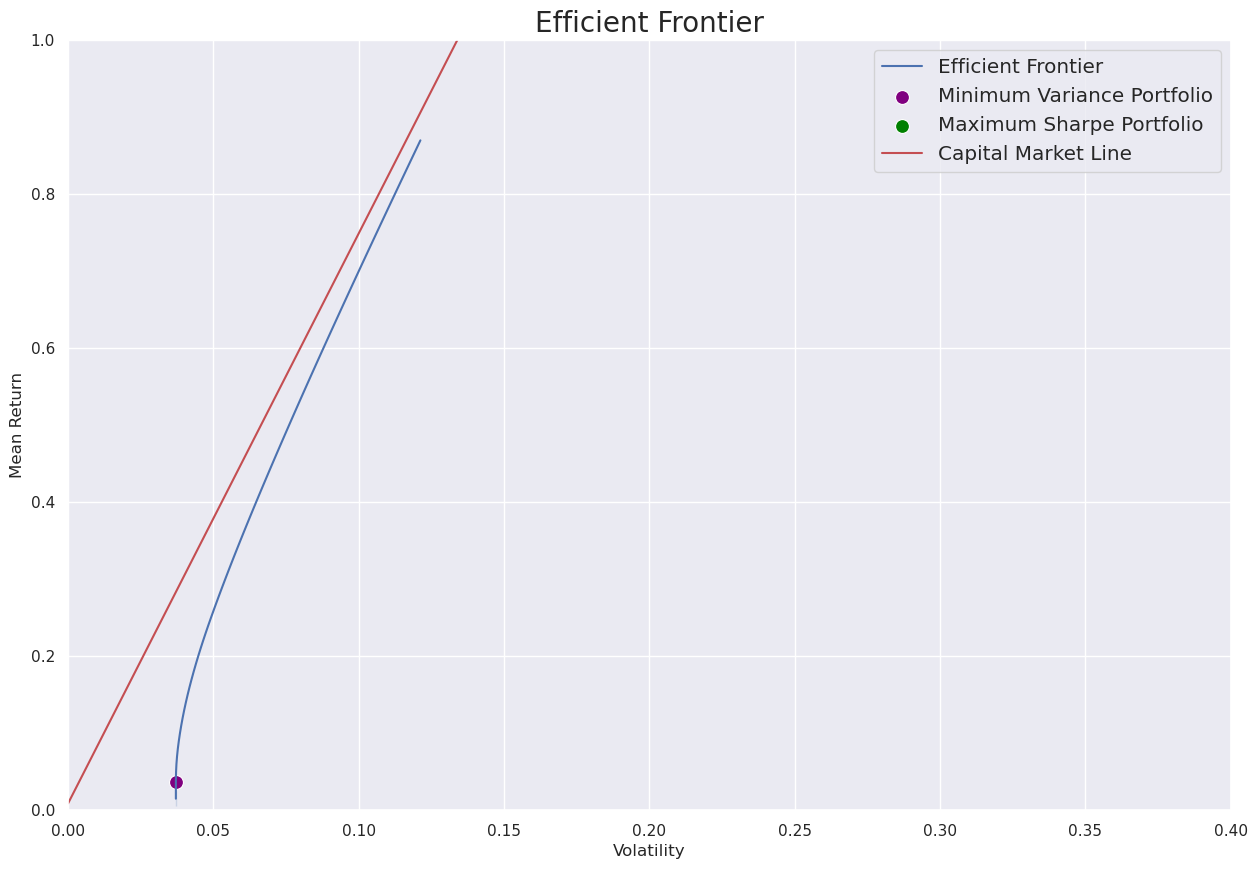

In [180]:
# plot the data
sns.set()

fig, ax = plt.subplots(figsize=[15, 10])

sns.lineplot(x=vol_ef, y=ret_ef, label="Efficient Frontier", ax=ax)
sns.scatterplot(
    x=[min_vol_vol],
    y=[min_vol_ret],
    ax=ax,
    label="Minimum Variance Portfolio",
    color="purple",
    s=100,
)
sns.scatterplot(
    x=[max_sharpe_vol],
    y=[max_sharpe_ret],
    ax=ax,
    label="Maximum Sharpe Portfolio",
    color="green",
    s=100,
)
sns.lineplot(
    x=[0, max_sharpe_vol, 1],
    y=[0.009, max_sharpe_ret, 3.096],
    label="Capital Market Line",
    ax=ax,
    color="r",
)

ax.set(xlim=[0, 0.4])
ax.set(ylim=[0, 1])
ax.set_xlabel("Volatility")
ax.set_ylabel("Mean Return")
plt.legend(fontsize="large")
plt.title("Efficient Frontier", fontsize="20")

ax.figure.savefig("EffFront_big.png", dpi=300)

In [181]:
raw_weights_minvar_exp
ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Expected annual return: 3.6%
Annual volatility: 3.7%
Sharpe Ratio: -0.10


(0.03627160035383953, 0.037074816893657124, -0.10056420930829572)

In [182]:
raw_weights_maxsharpe_exp
ef_sharp.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

Expected annual return: 226.3%
Annual volatility: 30.5%
Sharpe Ratio: 7.30


(2.2632719955398217, 0.3045412979042032, 7.300395745470213)

### BackTesting

In [183]:
import yfinance as yf

# Create a list of symbols
symbols = ["SPY"]
# Create data frame
index_data = yf.download(
    tickers=" ".join(symbols), start="2022-12-30", end="2023-12-30"
)["Adj Close"]

[*********************100%%**********************]  1 of 1 completed


In [184]:
index_data.describe

<bound method NDFrame.describe of Date
2022-12-30    375.537750
2023-01-03    373.956818
2023-01-04    376.843872
2023-01-05    372.542755
2023-01-06    381.085938
                 ...    
2023-12-22    472.182892
2023-12-26    474.176697
2023-12-27    475.034058
2023-12-28    475.213501
2023-12-29    473.837769
Name: Adj Close, Length: 251, dtype: float64>

In [185]:
index = pd.DataFrame(index_data)
index = index.rename(columns={"Adj Close":"SnP500"})
index.describe
# index.index

<bound method NDFrame.describe of                 SnP500
Date                  
2022-12-30  375.537750
2023-01-03  373.956818
2023-01-04  376.843872
2023-01-05  372.542755
2023-01-06  381.085938
...                ...
2023-12-22  472.182892
2023-12-26  474.176697
2023-12-27  475.034058
2023-12-28  475.213501
2023-12-29  473.837769

[251 rows x 1 columns]>

In [186]:
weights_minvar_exp = list(raw_weights_minvar_exp.values())
weights_maxsharpe_exp = list(raw_weights_maxsharpe_exp.values())

ret_1 = test.dot(weights_minvar_exp).add(1).cumprod().subtract(1).multiply(100)
ret_2 = test.dot(weights_maxsharpe_exp).add(1).cumprod().subtract(1).multiply(100)

ind_ret = index[date_cutoff:].pct_change().add(1).cumprod().subtract(1).multiply(100)

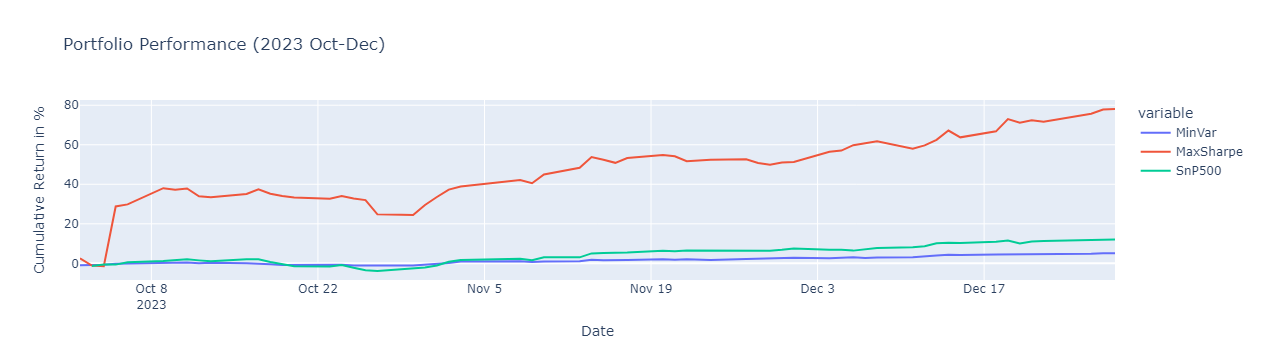

In [187]:
back = pd.DataFrame({"MinVar": ret_1, "MaxSharpe": ret_2})
back = pd.concat([back, ind_ret], join="outer", axis=1)
back.drop(back.tail(1).index, inplace=True)

back.interpolate(method="linear", inplace=True)

fig = px.line(
    back, x=back.index, y=back.columns, title="Portfolio Performance (2023 Oct-Dec)"
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Cumulative Return in %")

fig.show()